In [8]:
import pandas as pd
from textblob import TextBlob

In [11]:
df = pd.read_csv("https://raw.githubusercontent.com/Rui-kai/employee-sentiment-analysis/refs/heads/main/test(in).csv")


In [14]:
# task 1
def get_sentiment(text):
    tb = TextBlob(text)
    polarity = tb.sentiment.polarity
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['body'].fillna('').apply(get_sentiment)


df['Sentiment'].value_counts()


Sentiment
Neutral     1054
Positive     973
Negative     164
Name: count, dtype: int64

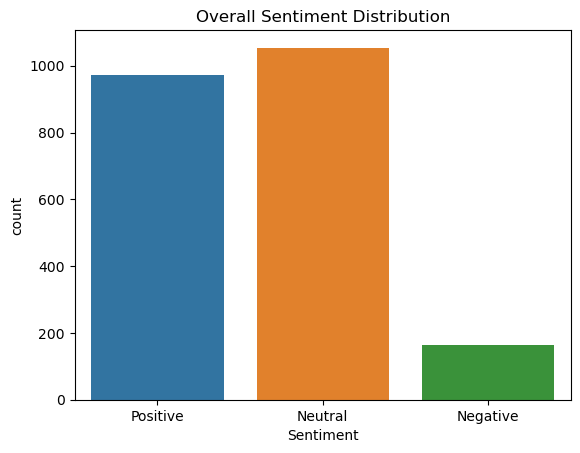

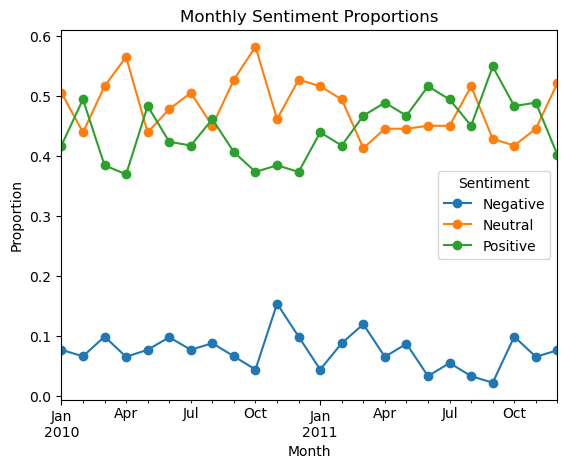

In [18]:
#task 2
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Sentiment', data=df)
plt.title('Overall Sentiment Distribution')
plt.show()

df['date'] = pd.to_datetime(df['date'])

monthly = df.set_index('date').groupby(pd.Grouper(freq='M'))['Sentiment'].value_counts(normalize=True).unstack()

monthly.plot(kind='line', marker='o')
plt.title('Monthly Sentiment Proportions')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.legend(title='Sentiment')
plt.show()


In [33]:
#task 3
score_map = {'Positive': +1, 'Negative': -1, 'Neutral': 0}
df['Score'] = df['Sentiment'].map(score_map)

df['YearMonth'] = df['date'].dt.to_period('M')
monthly_scores = df.groupby(['from', 'YearMonth'])['Score'].sum().reset_index()
monthly_scores.head()

,from,YearMonth,Score
0,bobette.riner@ipgdirect.com,2010-01,2
1,bobette.riner@ipgdirect.com,2010-02,7
2,bobette.riner@ipgdirect.com,2010-03,4
3,bobette.riner@ipgdirect.com,2010-04,2
4,bobette.riner@ipgdirect.com,2010-05,1


In [37]:
#task 4
def get_top_bottom(df_scores, yearmonth, top_n=3):
    sub = df_scores[df_scores['YearMonth']==yearmonth]
    top = sub.nlargest(top_n, 'Score')[['from','Score']]
    bottom = sub.nsmallest(top_n, 'Score')[['from','Score']]
    return top, bottom

#test date
top3, bot3 = get_top_bottom(monthly_scores, '2010-05')
top3, bot3

(                         from  Score
 28     don.baughman@enron.com      8
 172  patti.thompson@enron.com      7
 220      sally.beck@enron.com      6,
                             from  Score
 100      johnny.palmer@enron.com      0
 4    bobette.riner@ipgdirect.com      1
 76         john.arnold@enron.com      1)

In [41]:
#task 5


df['date'] = pd.to_datetime(df['date'])
df_sorted = df.sort_values(['from', 'date']).set_index('date')
df_sorted['IsNeg'] = (df_sorted['Sentiment'] == 'Negative').astype(int)
df_sorted['Neg30'] = (
    df_sorted.groupby('from')['IsNeg']
    .rolling('30D')
    .sum()
    .reset_index(level=0, drop=True)
)
risk_list = df_sorted[df_sorted['Neg30'] >= 4]['from'].unique()
risk_list



array(['bobette.riner@ipgdirect.com', 'johnny.palmer@enron.com',
       'lydia.delgado@enron.com', 'patti.thompson@enron.com',
       'rhonda.denton@enron.com', 'sally.beck@enron.com'], dtype=object)

In [43]:
#task 6
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


feat = df.groupby(['from','YearMonth']).agg(
    MsgCount=('body','size'),
    AvgScore=('Score','mean')
).reset_index()


feat['NextAvg'] = feat.groupby('from')['AvgScore'].shift(-1)
train = feat.dropna()

X = train[['MsgCount','AvgScore']]
y = train['NextAvg']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression().fit(X_tr, y_tr)
pred = model.predict(X_te)

print('MSE:', mean_squared_error(y_te, pred))

MSE: 0.061741507296026586
